In [132]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Keras. 

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.metrics import binary_crossentropy

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("white")

## Define categorical funcion. This prepares entries for tensor analysis. 

def to_categorical(y):
    return tf.keras.utils.to_categorical(y)


In [133]:
credit_card_df = pd.read_csv("/Users/Matt/Documents/GitHub/Credit-Card-Fraud-Detection/creditcard.csv")
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [134]:
# Pickout the valid transactions.

valid_transactions = credit_card_df.loc[credit_card_df['Class'] == 0.0]
fraudulent_transactions = credit_card_df.drop(valid_transactions.index)

In [135]:
# Create a more balanced data set. This training set will have a 50 / 50 split of valid and fraudulent transactions.
# I'll randomly sample 492 valid transactions and then add on the remaining 492 invalid transactions for a total of 
# 984. 

valid_sample = valid_transactions.sample(492)

# Shuffle the data 

sample_data_df = pd.concat([valid_sample, fraudulent_transactions]).sample(frac = 1, random_state = 42)

sample_data_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
42756,41233.0,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.00,1
113983,73287.0,1.202245,0.035993,0.673594,0.846058,-0.636044,-0.643119,-0.083282,-0.113017,0.496372,...,-0.289846,-0.679888,0.064032,0.403247,0.340998,0.179334,-0.015802,0.019367,17.39,0
111690,72327.0,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,-2.189871,...,0.801312,-0.183001,-0.440387,0.292539,-0.144967,-0.251744,1.249414,-0.131525,238.90,1
120303,75778.0,-2.448622,-1.267766,0.052177,1.703967,-3.227863,1.164250,3.586783,0.218217,-1.418245,...,0.657849,0.110527,2.229992,0.388572,0.318408,-0.379163,-0.088439,0.191091,992.52,0
31906,36557.0,1.290252,0.103967,-1.167062,-0.065915,2.205035,3.330085,-0.398459,0.797402,-0.125986,...,-0.228271,-0.796435,0.010025,0.967359,0.632698,-0.536768,0.021421,0.019394,4.29,0


In [136]:
# Scale the data. Must run the previous block before this one to avoid error.

from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

sample_data_df['scaled_amount'] = rob_scaler.fit_transform(sample_data_df['Amount'].values.reshape(-1,1))
sample_data_df['scaled_time'] = rob_scaler.fit_transform(sample_data_df['Time'].values.reshape(-1,1))

sample_data_df.drop(['Time','Amount'], axis=1, inplace=True)




In [137]:
#  Add them back in 

scaled_amount = sample_data_df['scaled_amount']
scaled_time = sample_data_df['scaled_time']

sample_data_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
sample_data_df.insert(0, 'scaled_amount', scaled_amount)
sample_data_df.insert(1, 'scaled_time', scaled_time)

# Now the amount and time are scaled.

sample_data_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42756,-0.196141,-0.466941,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,...,-0.046170,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,1
113983,-0.019548,-0.105878,1.202245,0.035993,0.673594,0.846058,-0.636044,-0.643119,-0.083282,-0.113017,...,-0.082191,-0.289846,-0.679888,0.064032,0.403247,0.340998,0.179334,-0.015802,0.019367,0
111690,2.229855,-0.116692,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,...,1.003350,0.801312,-0.183001,-0.440387,0.292539,-0.144967,-0.251744,1.249414,-0.131525,1
120303,9.882762,-0.077819,-2.448622,-1.267766,0.052177,1.703967,-3.227863,1.164250,3.586783,0.218217,...,2.231486,0.657849,0.110527,2.229992,0.388572,0.318408,-0.379163,-0.088439,0.191091,0
31906,-0.152577,-0.519612,1.290252,0.103967,-1.167062,-0.065915,2.205035,3.330085,-0.398459,0.797402,...,-0.017591,-0.228271,-0.796435,0.010025,0.967359,0.632698,-0.536768,0.021421,0.019394,0


In [138]:
# Set aside training/test data. 

sample_data_train = sample_data_df.sample(frac = .80, random_state = 440)
sample_data_test = sample_data_df.drop(sample_data_train.index)

In [139]:

# The training data:

X_train = np.array(sample_data_train.iloc[:, :-1])
y_train = np.array(sample_data_train.iloc[:, -1])

X_train = X_train.reshape(-1, 30)
y_train = y_train.reshape(-1, 1)

# And the test data:

X_test = np.array(sample_data_test.iloc[:, :-1])
y_test = np.array(sample_data_test.iloc[:, -1])

X_test = X_test.reshape(-1, 30)
y_test = y_test.reshape(-1, 1)


In [140]:
# Further split the training data into train_train/validation. 

from sklearn.model_selection import train_test_split

X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

# Check out the shape of the data. 

print(np.shape(X_train_train), type(X_train_train))
print(np.shape(y_train_train), type(y_train_train))
print(np.shape(X_val), type(X_val))
print(np.shape(y_val), type(y_val))
print('\n\n')
print(np.shape(to_categorical(y_train_train)), type(to_categorical(y_train_train)))
print(np.shape(to_categorical(y_val)), type(to_categorical(y_val)))

(629, 30) <class 'numpy.ndarray'>
(629, 1) <class 'numpy.ndarray'>
(158, 30) <class 'numpy.ndarray'>
(158, 1) <class 'numpy.ndarray'>



(629, 2) <class 'numpy.ndarray'>
(158, 2) <class 'numpy.ndarray'>


In [141]:
## Empty model
model = models.Sequential()

In [142]:
## Make the layers. ONLY RUN THIS ONCE. Make sure the input_shape matches the number of features.

model.add(layers.Dense(30, activation='relu', input_shape=(30,)))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

In [143]:
# Gives a model summary

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Here we compile the model. We use binary cross-entropy. 

model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [145]:
# Fitting the data. 

#history = model.fit(X_train_train,
#                        to_categorical(y_train_train),
#                        epochs = 100,
#                        batch_size = 512,
#                        validation_data=(X_val,to_categorical(y_val)))

# It looks like sparse_categorical automatically applies to_categorical to y, so use this one
# (this includes changed batch size and epochs):

history = model.fit(X_train_train,
                        y_train_train,
                        epochs = 100,
                        batch_size = 25,
                        validation_data=(X_val,y_val))

Epoch 1/100
26/26 [==============================] - 1s 12ms/step - loss: 1.7230 - accuracy: 0.5252 - val_loss: 0.4786 - val_accuracy: 0.7722
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.8209 - val_loss: 0.3668 - val_accuracy: 0.8544
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.3177 - accuracy: 0.8990 - val_loss: 0.2934 - val_accuracy: 0.8861
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.9264 - val_loss: 0.2524 - val_accuracy: 0.9114
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.9266 - val_loss: 0.2221 - val_accuracy: 0.9177
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.2078 - accuracy: 0.9364 - val_loss: 0.2030 - val_accuracy: 0.9304
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9522 - val_loss: 0.1862 - val_accuracy: 0.9304
Epoch 8/100


Epoch 59/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.2196 - val_accuracy: 0.9367
Epoch 60/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.2234 - val_accuracy: 0.9367
Epoch 61/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9367
Epoch 62/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.2253 - val_accuracy: 0.9367
Epoch 63/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2315 - val_accuracy: 0.9367
Epoch 64/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.2323 - val_accuracy: 0.9367
Epoch 65/100
26/26 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2363 - val_accuracy: 0.9367
Epoch 

In [146]:
# Examine the results. 

history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


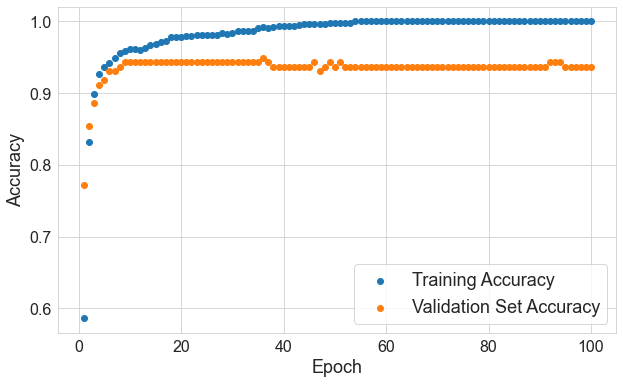

In [147]:
# That's... intersting. 

set_style("whitegrid")

plt.figure(figsize = (10,6))

plt.scatter(range(1,101), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,101), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

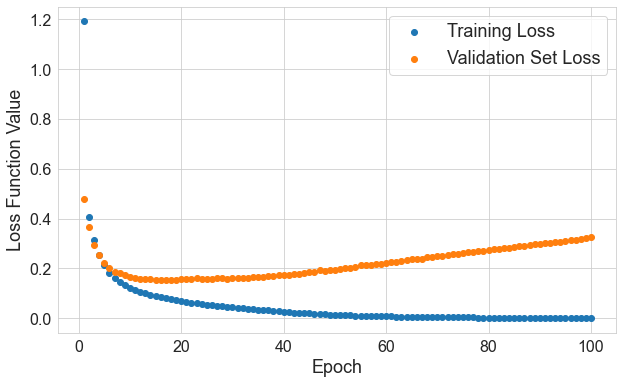

In [148]:
plt.figure(figsize = (10,6))

plt.scatter(range(1,101), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,101), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [149]:
# Value counts of test data. 

sample_data_test.value_counts('Class')

Class
0    101
1     96
dtype: int64

In [150]:
# Prediction.

y_pred_prob = model.predict(X_test)
print(len(y_pred))

# Set the threshold probability for valid transactions as p = 0.5. 

y_pred = []

for x in y_pred_prob:
    if x[0] > 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)
        
y_pred = np.array(y_pred)
y_pred

197


array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [151]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[97  4]
 [ 5 91]]


In [152]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9543147208121827


In [153]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       101
           1       0.96      0.95      0.95        96

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

